In [1]:
# import packages
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation

npr.seed(0)

In [128]:

# Set the parameters of the GLM-HMM
nstates = 3           # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(nstates, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

print(gen_weights.shape)
print(gen_log_trans_mat.shape)

(3, 1, 2)
(1, 3, 3)


Text(0.5, 0, 'state t + 1')

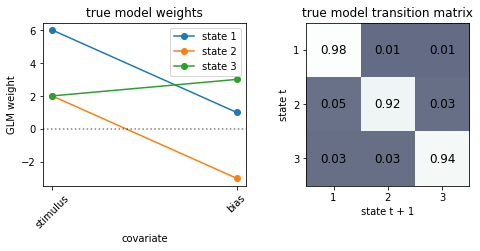

In [98]:
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3))

# plot true model GLM weights for each state
plt.subplot(1, 2, 1)

for kk in range(nstates):
    plt.plot(range(input_dim), gen_weights[kk][0], marker='o',
             linestyle='-',
             lw = 1.5, label="state " + str(kk+1))

# axis options    
plt.title("true model weights")
plt.ylabel("GLM weight")
plt.xlabel("covariate")
plt.xticks([0, 1], ['stimulus', 'bias'], rotation = 45)
plt.axhline(y=0, color="k", alpha = 0.5, ls = ":")
plt.legend()

# plot true model transition matrix
plt.subplot(1, 2, 2)
plt.imshow(true_glmhmm.transitions.transition_matrix, vmin=-0.8, vmax=1, cmap='bone')

for ii in range(nstates):
    for jj in range(nstates):
        text = plt.text(jj, ii, str(np.around(true_glmhmm.transitions.transition_matrix[ii, jj], decimals=2)), 
                        ha="center", va="center",
                        color="k", fontsize=12)
# axis options
plt.title("true model transition matrix")
plt.xticks(range(nstates), ('1', '2', '3'))
plt.yticks(range(nstates), ('1', '2', '3'))
plt.ylabel("state t")
plt.xlabel("state t + 1")

In [114]:
# creating external inputs
num_sess = 1 # number of example sessions
num_trials_per_sess = 100 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

In [136]:
# create a sequence of states and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

In [134]:
# calculate true loglikelihood
true_ll = true_glmhmm.log_probability(true_choices, inputs=inpts) 
print("true ll = " + str(true_ll))

print(true_choices)

true ll = -119.6623611632596
[array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]

  0%|          | 0/20 [00:00<?, ?it/s]

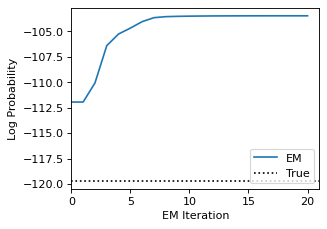

In [124]:
# new GLM
new_glmhmm = ssm.HMM(nstates, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 20 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()